In [1]:
%cd ../..

/home/eli/AnacondaProjects/epych


In [2]:
%env DASK_LOGGING__DISTRIBUTED=CRITICAL
%env SPYTMPDIR=/mnt/data/tmp_storage
%env SPYLOGLEVEL=CRITICAL
%env SPYPARLOGLEVEL=CRITICAL

env: DASK_LOGGING__DISTRIBUTED=CRITICAL
env: SPYTMPDIR=/mnt/data/tmp_storage
env: SPYLOGLEVEL=CRITICAL
env: SPYPARLOGLEVEL=CRITICAL


In [3]:
import collections
import functools
import logging
import matplotlib.pyplot as plt
import numpy as np
import os
import quantities as pq

import epych
from epych.statistics import alignment, spectrum

[striatum:1904678] shmem: mmap: an error occurred while determining whether or not /tmp/ompi.striatum.1000/jf.0/1421017088/shared_mem_cuda_pool.striatum could be created.
[striatum:1904678] create_and_attach: unable to create shared memory BTL coordinating structure :: size 134217728 


In [4]:
%matplotlib inline

In [5]:
logging.basicConfig(level=logging.INFO)

In [6]:
ADAPTED_ONSET = pq.Quantity(-1.0) * pq.second
ADAPTED_OFFSET = pq.Quantity(-0.5) * pq.second
ODDBALL_ONSET = pq.Quantity(-1.9017372477960602e-14) * pq.second
ODDBALL_OFFSET = pq.Quantity(0.5004545430388676) * pq.second
EVENTS = {
    "Adapted": (ADAPTED_ONSET.magnitude, 'lightgreen'),
    "Adapted Offset": (ADAPTED_OFFSET.magnitude, 'red'),
    "Oddball": (ODDBALL_ONSET.magnitude, 'lightgreen'),
    "Offset": (ODDBALL_OFFSET.magnitude, 'red'),
}

In [7]:
CONDITIONS = ["lonaive", "go_gloexp", "go_seqctl", "lo_gloexp", "lo_rndctl", "igo_seqctl"]
CONDITION_TITLES = {
    "lonaive": "Local Oddball Cue Trials",
    "go_gloexp": "Global Oddball",
    "go_seqctl": "AAAA Control",
    "lo_gloexp": "Local Oddball",
    "lo_rndctl": "AAAB Random",
    "igo_seqctl": "BBBB Control"
}

In [8]:
area_titles = {
    "VISal": "AL",
    "VISam": "AM",
    "VISl": "LM",
    "VISp": "V1",
    "VISpm": "PM",
    "VISrl": "RL",
}
def stattitle(name, stat):
    if name in area_titles:
        return area_titles[name]
    return name
anatomical_areas = ['VISp', 'VISl', 'VISrl', 'VISal', 'VISpm', 'VISam']

In [9]:
def condition_stattitle(cond, name, stat):
    return stattitle(name, stat) + (" (%s)" % CONDITION_TITLES[cond])

In [10]:
def initialize_spectrum(key, signal, path=None):
    area = os.path.commonprefix([loc for loc in signal.channels.location])
    return epych.statistics.spectrum.Spectrogram(signal.df, signal.channels, signal.f0, chunk_trials=3, taper="hann", path=path + "/" + key)

In [11]:
summaries = {}
tfr_summaries = {}

In [12]:
for cond in CONDITIONS:
    cond_path = "/mnt/data/000253/grand_spectrogram_downsample8_%s" % cond
    summaries[cond] = epych.statistic.Summary.unpickle(cond_path, epych.statistics.spectrum.Spectrogram)
    logging.info("Loaded LFP spectrograms across condition %s" % cond)

INFO:root:Loaded LFP spectrograms across condition lonaive
INFO:root:Loaded LFP spectrograms across condition go_gloexp
INFO:root:Loaded LFP spectrograms across condition go_seqctl
INFO:root:Loaded LFP spectrograms across condition lo_gloexp
INFO:root:Loaded LFP spectrograms across condition lo_rndctl
INFO:root:Loaded LFP spectrograms across condition igo_seqctl


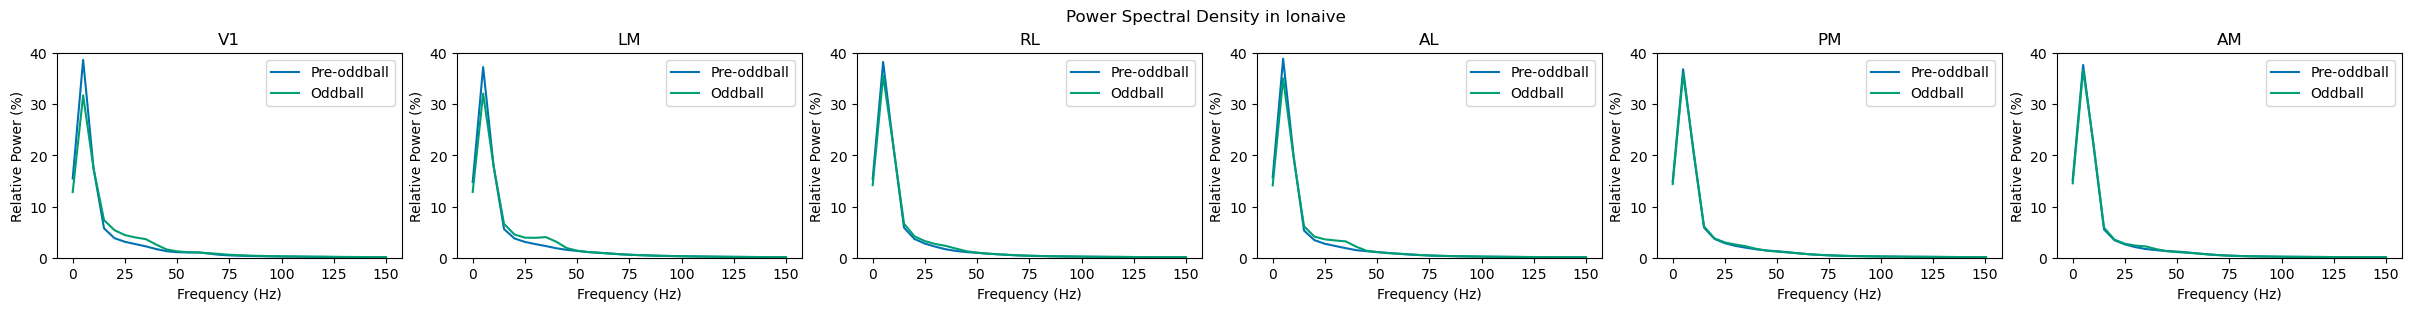

INFO:root:Plotted PSDs across condition lonaive


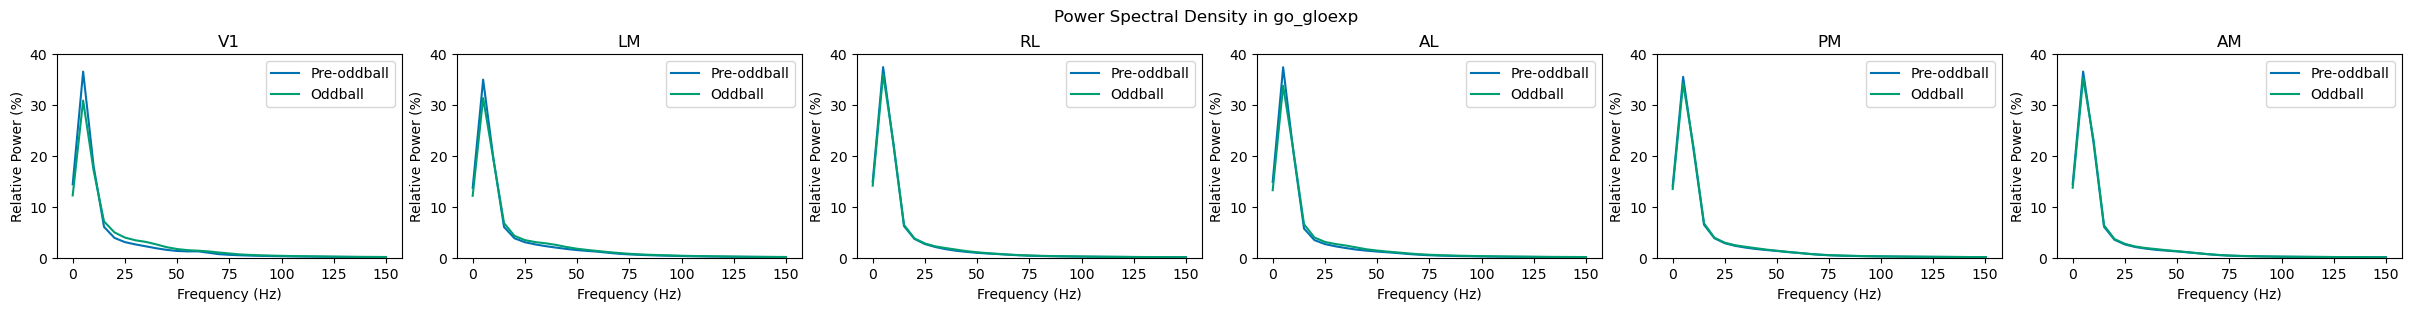

INFO:root:Plotted PSDs across condition go_gloexp


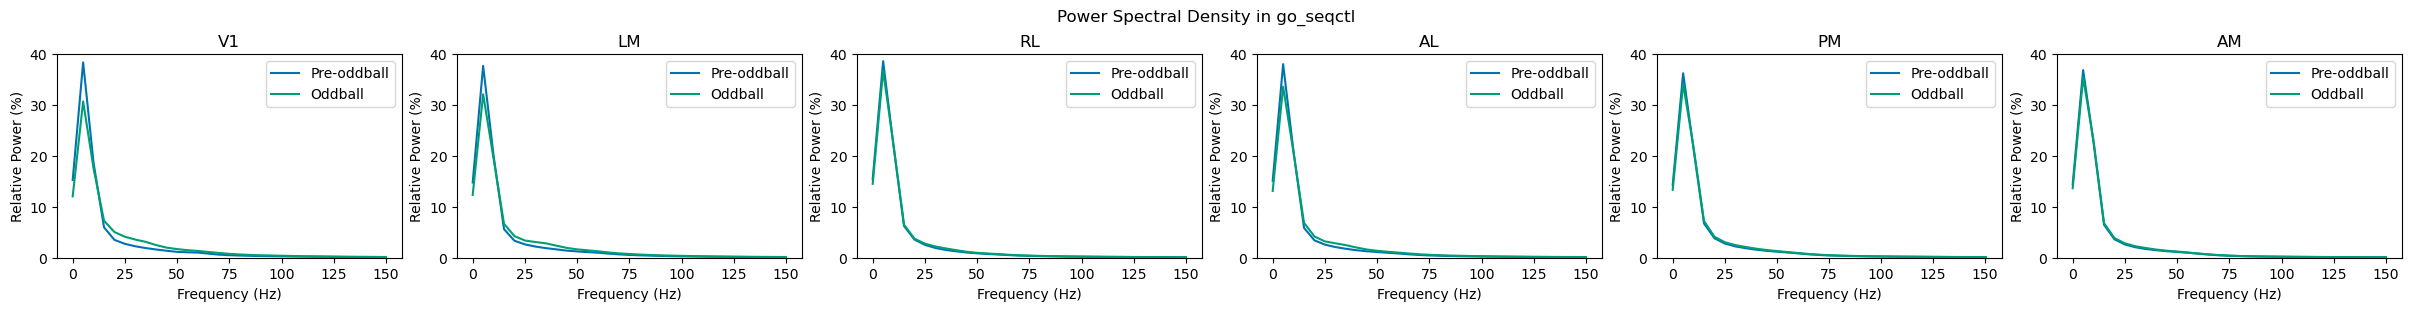

INFO:root:Plotted PSDs across condition go_seqctl


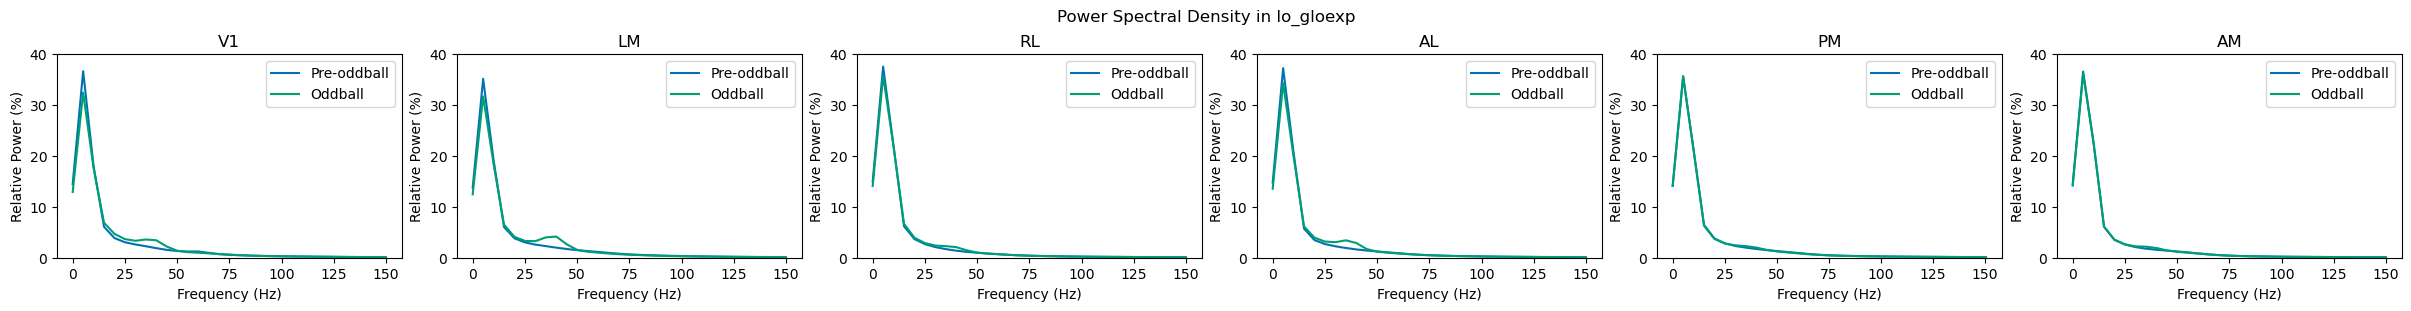

INFO:root:Plotted PSDs across condition lo_gloexp


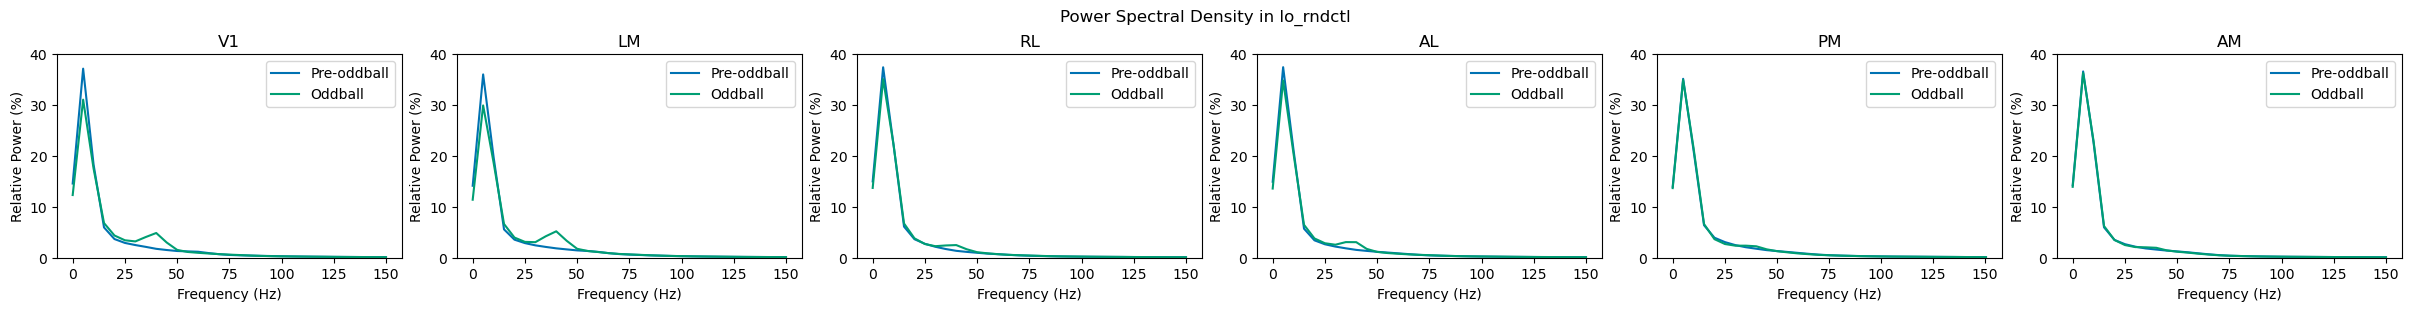

INFO:root:Plotted PSDs across condition lo_rndctl


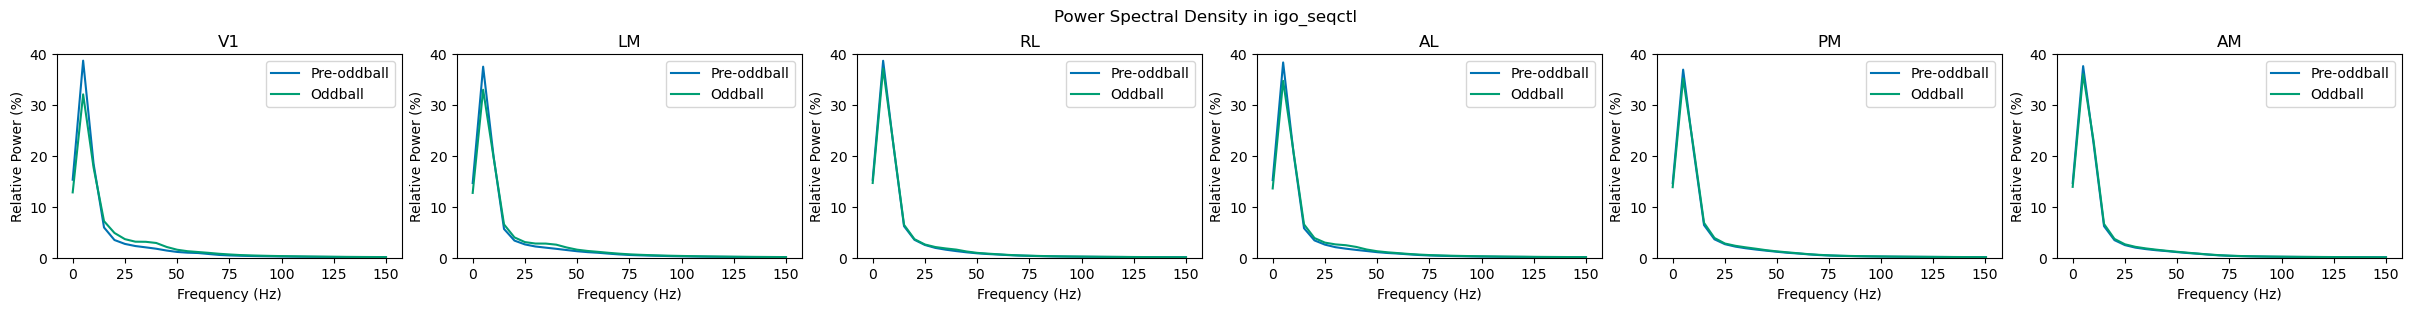

INFO:root:Plotted PSDs across condition igo_seqctl


In [13]:
for cond in CONDITIONS:
    cond_stattitle = functools.partial(condition_stattitle, cond)
    tfr_summaries[cond] = summaries[cond].results()

    fig, axes = plt.subplot_mosaic([anatomical_areas], figsize=(4 * len(anatomical_areas), 3), dpi=100, layout="compressed")

    for area, ax in axes.items():
        os.makedirs("grand_spectrogram_downsample8_%s/" % cond, exist_ok=True)
        psd = tfr_summaries[cond].signals[area][ADAPTED_OFFSET.magnitude:ODDBALL_ONSET.magnitude].channel_mean().power_spectrum().density().evoked()
        oddball_psd = tfr_summaries[cond].signals[area][ODDBALL_ONSET.magnitude:ODDBALL_OFFSET.magnitude].channel_mean().power_spectrum().density().evoked()

        ax.plot(psd.freqs, np.concatenate((psd.data, oddball_psd.data), axis=0).T * 100, label=['Pre-oddball', 'Oddball'])
        ax.legend(['Pre-oddball', 'Oddball'])
        ax.set_xlabel("Frequency (Hz)")
        ax.set_ylabel(r"Relative Power (%)")
        ax.set_title(stattitle(area, None))
        ax.set_ylim([0, 40])
    fig.suptitle("Power Spectral Density in %s" % cond)
    fig.savefig("grand_spectrogram_downsample8_%s/%s_psd_comparison.pdf" % (cond, area))
    plt.show()
    plt.close(fig)
    logging.info("Plotted PSDs across condition %s" % cond)

In [14]:
BAND_POWERS = {}

for cond in tfr_summaries.keys():
    cond_spectra = tfr_summaries[cond].smap(lambda sig: sig.channel_mean())
    BAND_POWERS[cond] = {}

    for area in anatomical_areas:
        area_spectra = cond_spectra.signals[area][ODDBALL_ONSET.magnitude:ODDBALL_OFFSET.magnitude].power_spectrum().density()
        theta = area_spectra.band_power(spectrum.THETA_BAND[0].magnitude, spectrum.THETA_BAND[1].magnitude)
        alphabeta = area_spectra.band_power(10, 19)
        gamma = area_spectra.band_power(75, 150)
        BAND_POWERS[cond][area] = (theta, alphabeta, gamma)
        logging.info("%s - %s: $\\theta$ = %f $\\pm$ %f, $\\alpha/\\beta$ = %f $\\pm$ %f, $\\gamma$ = %f $\\pm$ %f" % (cond, stattitle(area, None),
                                                                                                                       theta.mean().item(), theta.std().item(),
                                                                                                                       alphabeta.mean().item(), alphabeta.std().item(),
                                                                                                                       gamma.mean().item(), gamma.std().item()))

INFO:root:lonaive - V1: $\theta$ = 0.206475 $\pm$ 0.045902, $\alpha/\beta$ = 0.100434 $\pm$ 0.022893, $\gamma$ = 0.002603 $\pm$ 0.001642
INFO:root:lonaive - LM: $\theta$ = 0.209500 $\pm$ 0.048478, $\alpha/\beta$ = 0.096918 $\pm$ 0.017297, $\gamma$ = 0.002602 $\pm$ 0.001611
INFO:root:lonaive - RL: $\theta$ = 0.237442 $\pm$ 0.032400, $\alpha/\beta$ = 0.107779 $\pm$ 0.018757, $\gamma$ = 0.001979 $\pm$ 0.001072
INFO:root:lonaive - AL: $\theta$ = 0.229332 $\pm$ 0.042046, $\alpha/\beta$ = 0.099556 $\pm$ 0.016516, $\gamma$ = 0.002063 $\pm$ 0.001198
INFO:root:lonaive - PM: $\theta$ = 0.237408 $\pm$ 0.033974, $\alpha/\beta$ = 0.102683 $\pm$ 0.019228, $\gamma$ = 0.002268 $\pm$ 0.001517
INFO:root:lonaive - AM: $\theta$ = 0.244523 $\pm$ 0.031279, $\alpha/\beta$ = 0.105139 $\pm$ 0.020608, $\gamma$ = 0.001852 $\pm$ 0.001025
INFO:root:go_gloexp - V1: $\theta$ = 0.201054 $\pm$ 0.042586, $\alpha/\beta$ = 0.097663 $\pm$ 0.020874, $\gamma$ = 0.003449 $\pm$ 0.001880
INFO:root:go_gloexp - LM: $\theta$ = 0.